### Downlaoding and Unzipping the dataset

In [3]:
!kaggle datasets download gpiosenka/sports-classification

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/sports-classification
License(s): CC0-1.0
100%|████████████████████████████████████████| 424M/424M [00:41<00:00, 11.6MB/s]
100%|████████████████████████████████████████| 424M/424M [00:41<00:00, 10.8MB/s]


In [197]:
# Unzipping the dataset
!unzip "sports-classification.zip"

Archive:  sports-classification.zip
  inflating: EfficientNetB0-100-(224 X 224)- 98.40.h5  
  inflating: sports.csv              
  inflating: test/air hockey/1.jpg   
  inflating: test/air hockey/2.jpg   
  inflating: test/air hockey/3.jpg   
  inflating: test/air hockey/4.jpg   
  inflating: test/air hockey/5.jpg   
  inflating: test/ampute football/1.jpg  
  inflating: test/ampute football/2.jpg  
  inflating: test/ampute football/3.jpg  
  inflating: test/ampute football/4.jpg  
  inflating: test/ampute football/5.jpg  
  inflating: test/archery/1.jpg      
  inflating: test/archery/2.jpg      
  inflating: test/archery/3.jpg      
  inflating: test/archery/4.jpg      
  inflating: test/archery/5.jpg      
  inflating: test/arm wrestling/1.jpg  
  inflating: test/arm wrestling/2.jpg  
  inflating: test/arm wrestling/3.jpg  
  inflating: test/arm wrestling/4.jpg  
  inflating: test/arm wrestling/5.jpg  
  inflating: test/axe throwing/1.jpg  
  inflating: test/axe throwing/2.jpg  
  

In [331]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from torch.utils.data import Dataset

### Data Verification

Since you dataset is stored locally in our directory thus we actually need to implmenet a custom dataset class for loading our data into the dataloaders.But before that let us check if there are some corrupt image files.

In [232]:
# Path to dataset folders
datasets = ["train", "test", "valid"]
count = 0

for dataset in datasets:
    # Iterate over files in the dataset directory
    for root, dirs, files in os.walk(dataset):
        for file in files:
            file_path = os.path.join(root, file)
            
            # Check file extension (optional but recommended)
            if not file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff')):
                continue
            
            try:
                # Try to read the image
                with Image.open(file_path) as img:
                    img.verify()  # Verify image integrity
                
            except (IOError, OSError) as e:
                # Log corrupted file and remove it
                print(f"Error reading {file_path}: {e}")
                os.remove(file_path)
                count += 1

print(f"Total corrupt files: {count}")

Total corrupt files: 0


### Creation of train,test and validation sets

In [204]:
# Helper function to process dataset
def create_dataset_list(base_dir):
    dataset = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            file_path = os.path.join(root, file)
            
            # Extract label from the directory name
            label = os.path.basename(root)  # Using the immediate parent directory as the label
            
            dataset.append({'file_path': file_path, 'label': label})
    return dataset

# Process each dataset
train_data = create_dataset_list("train")
test_data = create_dataset_list("test")
valid_data = create_dataset_list("valid")

# Convert to dataframes
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
valid_df = pd.DataFrame(valid_data)

In [234]:
labels = np.unique(train_df.label)

# Create a dictionary for mapping
class_to_idx = {label: idx for idx, label in enumerate(labels)}

# Map string labels to integers directly
train_df['label'] = train_df['label'].map(class_to_idx)
test_df['label'] = test_df['label'].map(class_to_idx)
valid_df['label'] = valid_df['label'].map(class_to_idx)

In [238]:
# Saving the dataframes
train_df.to_csv("Train_Annotation_File.csv",index=False)
test_df.to_csv("Test_Annotation_File.csv",index=False)
valid_df.to_csv("Valid_Annotation_File.csv",index=False)

In [332]:
# loading the csv files
train_df = pd.read_csv("Train_Annotation_File.csv")
test_df = pd.read_csv("Train_Annotation_File.csv")
valid_df = pd.read_csv("Valid_Annotation_File.csv")

In [333]:
print(train_df.shape,test_df.shape,valid_df.shape)

(13493, 2) (13493, 2) (500, 2)


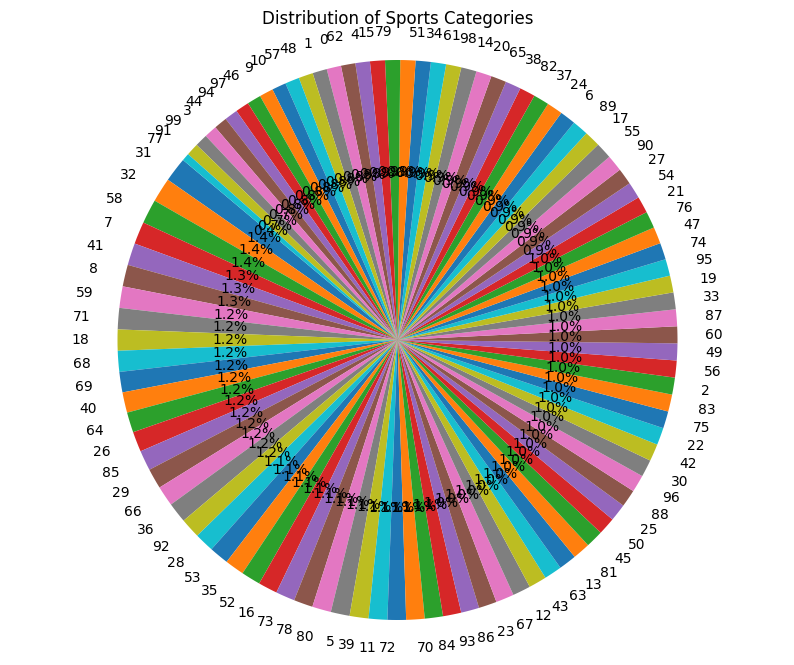

In [240]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each label
label_counts = train_df['label'].value_counts()

# Create a pie chart
plt.figure(figsize=(10, 8))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sports Categories')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()

### Creating the dataloaders

In [334]:
classes_count = len(os.listdir("train"))
print(f"Total classes in the dataset {classes_count}")

Total classes in the dataset 100


In [335]:
import torch
from torchvision.transforms import v2,Lambda,ToTensor

# Defining the transformation we need to do on the input data
feature_transforms = v2.Compose([
    v2.Resize(32),
    v2.RandomHorizontalFlip(p=0.5),
    ToTensor(),  # Convert to FloatTensor and scale to [0, 1]
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Defining the transformation for the target label
target_transforms = Lambda(lambda y: torch.zeros(classes_count, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y, dtype=torch.int64), value=1))


In [336]:
from PIL import Image, UnidentifiedImageError
from torch.utils.data import Dataset
from pathlib import Path

# Define a helper function to check if the file is a .jpg image
def is_jpg_file(filepath):
    return Path(filepath).suffix.lower() == '.jpg'

class CustomImageDataset(Dataset):
    
    def __init__(self, annotations_file, transform=None, target_transform=None):
        self.image_label_df = pd.read_csv(annotations_file)
        self.transform = transform
        self.target_transform = target_transform

        # Filter out all non-".jpg" images from the DataFrame
        self.image_label_df = self.image_label_df[self.image_label_df.iloc[:, 0].apply(is_jpg_file)]

    def __len__(self):
        return len(self.image_label_df)

    def __getitem__(self, idx):
        # Reading the image file as a PIL Image
        img_path = self.image_label_df.iloc[idx, 0]
        
        try:
            image = Image.open(img_path).convert("RGB")  # Ensures image is in RGB format
        except UnidentifiedImageError:
            print(f"Skipping invalid image file: {img_path}")
            image = Image.new("RGB", (32, 32))  # Create a blank image or skip

        # Get the corresponding label
        label = int(self.image_label_df.iloc[idx, 1])

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)

        # Return the image and its corresponding label
        return image, label

# Create dataset instances
train_dataset = CustomImageDataset(
    annotations_file="Train_Annotation_File.csv",
    transform=feature_transforms,
    target_transform=target_transforms,
)

test_dataset = CustomImageDataset(
    annotations_file="Test_Annotation_File.csv",
    transform=feature_transforms,
    target_transform=target_transforms,
)

valid_dataset = CustomImageDataset(
    annotations_file="Valid_Annotation_File.csv",
    transform=feature_transforms,
    target_transform=target_transforms,
)

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [337]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=True)

### Defining the Neural network

- **`import torch`**
  - Imports the main PyTorch library.
  - Provides functionalities for tensor operations, automatic differentiation, and GPU acceleration.
  - Tensors are the fundamental data structure in PyTorch, similar to NumPy arrays but optimized for deep learning.

- **`import torch.nn as nn`**
  - Imports the `torch.nn` module.
  - Contains classes and functions to build neural network layers and architectures.
  - Provides pre-defined layers (e.g., convolutional layers, pooling layers, fully connected layers) and loss functions.

- **`import torch.nn.functional as F`**
  - Imports the functional interface of the `torch.nn` module.
  - Includes functions for operations on tensors, such as activation functions (e.g., ReLU, sigmoid) and loss functions.
  - Allows for more flexibility in defining the forward pass of a model.

In [338]:
import torch.nn as nn
import torch.nn.functional as F

# Getting the device for training
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


- Check dimensionality of the image
- How to find feature maps
- Map input to output

In [320]:
# !pip install netron
# !pip install onnx onnxruntime

In [339]:
class LeNet5(nn.Module):
    def __init__(self, num_classes=100):  
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        # Calculate the size after the convolutions and pooling for an input size of 32*32
        # After conv1: (32 - 5 + 1) = 28
        # After pool1: (28 / 2) = 14
        # After conv2: (14 - 5 + 1) = 10
        # After pool2: (10 / 2) = 5
        self.fc1 = nn.Linear(16 * 5 * 5, 120)  # Input size for fc1 updated for 32*32 input
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)  # Output size updated to 100

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)  # Flattening size updated for 32*32 input
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = LeNet5(num_classes=100).to(device) 

In [340]:
dummy_input = torch.randn(1, 3, 32, 32).to(device)

torch.onnx.export(
    model,
    dummy_input,
    "architectures/lenet5.onnx",
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    verbose=True
)
print("Model exported to architecture/lenet5.onnx")

Exported graph: graph(%input : Float(*, 3, 32, 32, strides=[3072, 1024, 32, 1], requires_grad=0, device=mps:0),
      %conv1.weight : Float(6, 3, 5, 5, strides=[75, 25, 5, 1], requires_grad=1, device=mps:0),
      %conv1.bias : Float(6, strides=[1], requires_grad=1, device=mps:0),
      %conv2.weight : Float(16, 6, 5, 5, strides=[150, 25, 5, 1], requires_grad=1, device=mps:0),
      %conv2.bias : Float(16, strides=[1], requires_grad=1, device=mps:0),
      %fc1.weight : Float(120, 400, strides=[400, 1], requires_grad=1, device=mps:0),
      %fc1.bias : Float(120, strides=[1], requires_grad=1, device=mps:0),
      %fc2.weight : Float(84, 120, strides=[120, 1], requires_grad=1, device=mps:0),
      %fc2.bias : Float(84, strides=[1], requires_grad=1, device=mps:0),
      %fc3.weight : Float(100, 84, strides=[84, 1], requires_grad=1, device=mps:0),
      %fc3.bias : Float(100, strides=[1], requires_grad=1, device=mps:0)):
  %/conv1/Conv_output_0 : Float(*, 6, 28, 28, strides=[4704, 784, 28

In [348]:
X = torch.randn(128, 3, 32, 32).to(device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([85, 85, 85, 85, 62, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85,
        85, 85, 85, 18, 98, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85,
        85, 85, 85, 85, 85, 18, 17, 85, 85, 85, 85, 85, 85, 85, 18, 85, 85, 85,
        85, 85, 85, 85, 85, 85, 85, 62, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85,
        85, 98, 85, 85, 85, 85, 85, 85, 85, 85, 28, 85, 85, 85, 85, 85, 85, 28,
        85, 85, 85, 85, 85, 85, 85, 17, 85, 18, 85, 85, 85, 85, 85, 62, 85, 98,
        85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85, 85,
        85, 85], device='mps:0')


In [357]:
y_pred.shape

torch.Size([128])

In [342]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: LeNet5(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=100, bias=True)
)


Layer: conv1.weight | Size: torch.Size([6, 3, 5, 5]) | Values : tensor([[[[-0.0040,  0.0842, -0.0971,  0.0536, -0.0492],
          [ 0.0377, -0.0972,  0.0081,  0.0279, -0.0111],
          [-0.0488, -0.0616, -0.0602, -0.0283,  0.0235],
          [-0.0546, -0.0723,  0.0354, -0.0257, -0.0576],
          [-0.0933, -0.0772, -0.0556,  0.0264, -0.0508]],

         [[-0.1002,  0.0301,  0.0011, -0.0695, -0.1107],
          [ 0.0978,  0.0818,  0.0486,  0.0509, -0.0605],
          [-0.1060, -0.0413,  0

### Defining the training and testing

In [343]:
learning_rate = 1e-3
batch_size = 128
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [345]:
for batch, (X, y) in enumerate(train_dataloader):
    print(y.shape)
    break

torch.Size([128, 100])


In [354]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Move data to the device (GPU/CPU)
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients
        optimizer.step()  # Update model weights

        # Logging every 100th batch
        if batch % 100 == 0:
            loss_item = loss.item()
            current = batch * len(X)  # Correct the current calculation
            print(f"loss: {loss_item:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn,device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(dim=1) == y.argmax(dim=1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

### Defining parameters for training

In [355]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer,device)
    test_loop(test_dataloader, model, loss_fn,device)
print("Done!")

Epoch 1
-------------------------------
loss: 4.612128  [    0/13492]
loss: 4.609976  [12800/13492]
Prediction shape:torch.Size([128])
Actual shapetorch.Size([128, 100])


RuntimeError: The size of tensor a (128) must match the size of tensor b (100) at non-singleton dimension 1

In [ ]:
# Callable is a python object that can be called via parenthesis and also the object which internally have __call__ method impelmented